<a href="https://colab.research.google.com/github/aashinsravan/Deep-Learning/blob/main/Wildlife_Fire_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Installation

In [19]:
 ! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Mounting the Drive and Loading the Dataset

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
! mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [22]:
! cp /content/drive/MyDrive/Colab\ Notebooks/kaggle_API/kaggle.json ~/.kaggle/kaggle.json

In [23]:
! chmod 600 ~/.kaggle/kaggle.json

In [24]:
#Downloading the dataset
!kaggle datasets download -d abdelghaniaaba/wildfire-prediction-dataset

 99% 1.44G/1.45G [00:16<00:00, 101MB/s] 
100% 1.45G/1.45G [00:16<00:00, 95.9MB/s]


In [25]:
#Unzipping the dataset
!unzip wildfire-prediction-dataset.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/valid/nowildfire/-73.465183,45.443641.jpg  
  inflating: /content/valid/nowildfire/-73.465388,45.584881.jpg  
  inflating: /content/valid/nowildfire/-73.469451,45.480331.jpg  
  inflating: /content/valid/nowildfire/-73.471252,45.51974.jpg  
  inflating: /content/valid/nowildfire/-73.472693,45.427766.jpg  
  inflating: /content/valid/nowildfire/-73.473015,45.435254.jpg  
  inflating: /content/valid/nowildfire/-73.475051,45.56612.jpg  
  inflating: /content/valid/nowildfire/-73.477079,45.597274.jpg  
  inflating: /content/valid/nowildfire/-73.478813,45.555686.jpg  
  inflating: /content/valid/nowildfire/-73.479478,45.524618.jpg  
  inflating: /content/valid/nowildfire/-73.480135,45.528248.jpg  
  inflating: /content/valid/nowildfire/-73.480722,45.518864.jpg  
  inflating: /content/valid/nowildfire/-73.481149,45.563113.jpg  
  inflating: /content/valid/nowildfire/-73.481422,45.559789.jpg  
  inflating: /content/valid

# Loading Libraries

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from keras.optimizers import SGD, adam


# Pre-Processing

Parameters

In [43]:
EPOCH= 2
BATCH_SIZE= 64
TRGT_SIZE =(64,64)

Assigning the paths

In [44]:
train_path='/content/train'
test_path='/content/test'
val_path='/content/valid'

Setting up image data generator

In [57]:
train_datagen= ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2, 
                                  zoom_range=0.2, 
                                  horizontal_flip=True,
                                  rotation_range=75)

test_datagen= ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(train_path, 
                                                  target_size=TRGT_SIZE, 
                                                  batch_size=BATCH_SIZE, 
                                                  class_mode='categorical',
                                                  shuffle=False)

val_generator = test_datagen.flow_from_directory(val_path,
                                                  target_size=TRGT_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False)

test_generator = test_datagen.flow_from_directory(test_path,
                                                   target_size=TRGT_SIZE,
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=False)


Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


# Defining the Model

In [46]:
model=Sequential()

model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu',  kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu',  kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=2, activation='softmax'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 256)       

# Compiling the Model


In [47]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

model.compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','AUC'])

# Training the Model

In [49]:
checkpoint = ModelCheckpoint('model.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)
with tf.device('/GPU:0'):
  history = model.fit( train_generator,
                    epochs=5,
                    verbose=1,
                    validation_data = val_generator,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/5
473/473 [==============================] - ETA: 0s - loss: 0.4617 - accuracy: 0.7848 - auc: 0.8665
Epoch 1: val_loss improved from inf to 0.32044, saving model to model.hdf5
473/473 [==============================] - 144s 304ms/step - loss: 0.4617 - accuracy: 0.7848 - auc: 0.8665 - val_loss: 0.3204 - val_accuracy: 0.8435 - val_auc: 0.9378
Epoch 2/5
473/473 [==============================] - ETA: 0s - loss: 0.3229 - accuracy: 0.8748 - auc: 0.9375
Epoch 2: val_loss improved from 0.32044 to 0.29966, saving model to model.hdf5
473/473 [==============================] - 138s 292ms/step - loss: 0.3229 - accuracy: 0.8748 - auc: 0.9375 - val_loss: 0.2997 - val_accuracy: 0.8692 - val_auc: 0.9458
Epoch 3/5
473/473 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.8909 - auc: 0.9526
Epoch 3: val_loss did not improve from 0.29966
473/473 [==============================] - 138s 292ms/step - loss: 0.2792 - accuracy: 0.8909 - auc: 0.9526 - val_loss: 0.3143 - val_accura

# Plotting

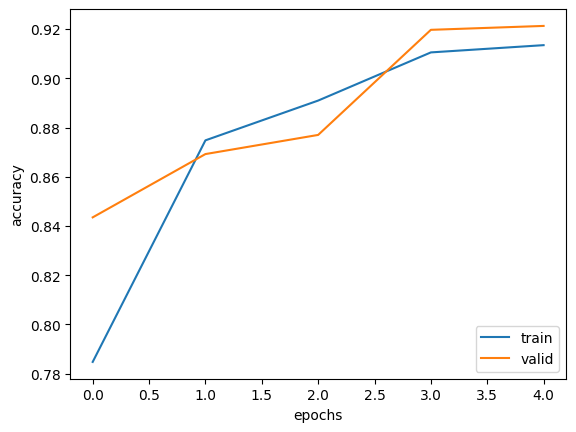

In [50]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label = 'train',)
plt.plot(history.history['val_accuracy'], label = 'valid')

# adding legend and labels
plt.legend(loc = 'lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')

# show the plot
plt.show()   

# Testing the Test Set

Classification Report

In [58]:
from sklearn.metrics import classification_report
# Load the saved model
model.load_weights('model.hdf5')

# Evaluate the model on the test set
scores = model.evaluate(test_generator, verbose=1)
print(f"Test loss: {scores[0]}")
print(f"Test accuracy: {scores[1]}")

# Predict the labels of the test set
y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(y_pred)
# Compute evaluation metrics
print(classification_report(test_generator.classes, y_pred))


99/99 [==============================] - 19s 195ms/step - loss: 0.1813 - accuracy: 0.9313 - auc: 0.9804
Test loss: 0.1812564581632614
Test accuracy: 0.9312698245048523
99/99 [==============================] - 21s 204ms/step
[0 0 0 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2820
           1       0.94      0.94      0.94      3480

    accuracy                           0.93      6300
   macro avg       0.93      0.93      0.93      6300
weighted avg       0.93      0.93      0.93      6300



Confusion Matrix

99/99 [==============================] - 18s 179ms/step


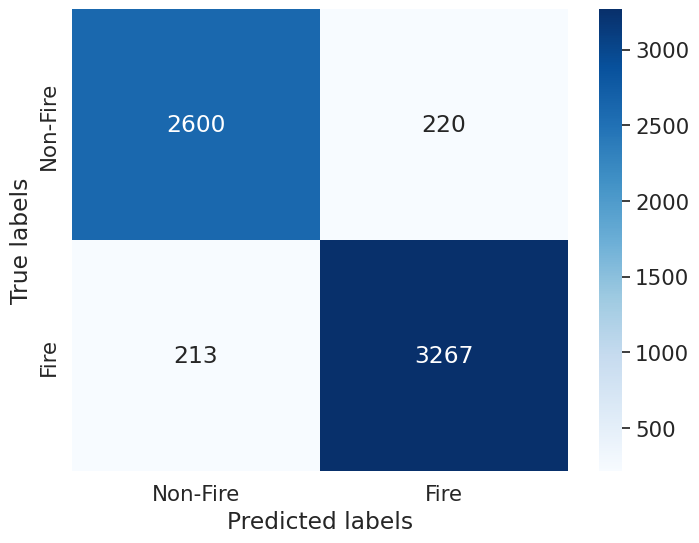

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved model
model.load_weights('model.hdf5')

# Predict the labels of the test set
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

# Define class labels
class_names = ['Non-Fire', 'Fire']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
